In [1]:
import sys, os, re
import json
import datetime, iso8601

base_path = ".."

## Setup PySpark Environment

In [2]:
APP_NAME = "Debugging Prediction Problems"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


## Load Training DataFrame

In [3]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),  # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),  # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),  # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),  # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True),  # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),  # "DepDelay":14.0
  StructField("Dest", StringType(), True),  # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),  # "Distance":368.0
  StructField("FlightDate", DateType(), True),  # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),  # "FlightNum":"6109"
  StructField("Origin", StringType(), True),  # "Origin":"TUS"
])

input_path = "{}/data/simple_flight_delay_features.json".format(base_path)

features = spark.read.json(
  input_path,
  schema=schema
)
features.select("ArrDelay", "CRSArrTime", "CRSDepTime", "Carrier", "DepDelay", 
                "Origin", "Dest", "FlightDate", "FlightNum", "Distance").show(12)

+--------+--------------------+--------------------+-------+--------+------+----+----------+---------+--------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DepDelay|Origin|Dest|FlightDate|FlightNum|Distance|
+--------+--------------------+--------------------+-------+--------+------+----+----------+---------+--------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|    14.0|   ABQ| DFW|2014-12-31|     1024|   569.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|    14.0|   ABQ| DFW|2014-12-31|     1184|   569.0|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|    -2.0|   ABQ| DFW|2014-12-31|      336|   569.0|
|   -21.0|2015-01-01 11:30:...|2015-01-01 09:55:...|     AA|    -1.0|   ATL| DFW|2014-12-31|      125|   731.0|
|   -14.0|2015-01-01 02:25:...|2015-01-01 00:55:...|     AA|    -4.0|   ATL| DFW|2014-12-31|     1455|   731.0|
|    16.0|2015-01-01 07:15:...|2015-01-01 05:45:...|     AA|    15.0|   ATL| DFW|2014-12-31|     1473|  

## Reproduce the ArrDelay Bucketing

In [4]:
# Load the arrival delay bucketizer
from pyspark.ml.feature import Bucketizer

# Load the departure delay bucketizer
arrival_bucketizer_path = "{}/models/arrival_bucketizer.bin".format(base_path)
arrival_bucketizer = Bucketizer.load(arrival_bucketizer_path)

# Bucketize the departure and arrival delays for classification
ml_bucketized_features = arrival_bucketizer.transform(features)
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(10)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           0.0|
|    17.0|           1.0|
|    36.0|           1.0|
|   -21.0|           0.0|
|   -14.0|           0.0|
|    16.0|           1.0|
|    -7.0|           0.0|
|    13.0|           0.0|
|    25.0|           1.0|
|    58.0|           1.0|
+--------+--------------+
only showing top 10 rows



## Check the `ArrDelayBucket` Distribution
Lets start by checking the overall range of flight delays.

In [66]:
# Check the frequency of each category
ml_bucketized_features.registerTempTable("ml_bucketized_features")

spark.sql("SELECT MIN(ArrDelay), MAX(ArrDelay) FROM ml_bucketized_features").show()

+-------------+-------------+
|min(ArrDelay)|max(ArrDelay)|
+-------------+-------------+
|        -87.0|       1971.0|
+-------------+-------------+



And now lets check the distribution of arrival delays as they fall into our bucketing scheme.

In [5]:
spark.sql(
"""
SELECT
  ArrDelayBucket,
  COUNT(*) AS Total,
  ROUND(
    100 * (COUNT(*)/(SELECT COUNT(*) FROM ml_bucketized_features)),
    2
  ) AS Total_Pct
FROM ml_bucketized_features
GROUP BY ArrDelayBucket
"""
).show()

+--------------+-------+---------+
|ArrDelayBucket|  Total|Total_Pct|
+--------------+-------+---------+
|           0.0|4650569|    81.39|
|           1.0| 737848|    12.91|
|           2.0| 325591|      5.7|
+--------------+-------+---------+



The results are pretty skewed, with 81.4% in `ArrDelayBucket` `0.0`. Note that our model always predicts `0.0`...

## Sampling `ArrDelayBucket` `0.0`
Lets take a look at some example values in the largest bucket, bucket `0.0`. Lets sample it before we inspect it.

In [6]:
# Check out some values from the field
spark.sql("SELECT ArrDelay, ArrDelayBucket "
          "FROM ml_bucketized_features "
          "WHERE ArrDelayBucket == 0.0")\
  .sample(False, 0.01, 11).show(15)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|   -31.0|           0.0|
|   -26.0|           0.0|
|    -7.0|           0.0|
|    -9.0|           0.0|
|    -7.0|           0.0|
|     6.0|           0.0|
|     0.0|           0.0|
|    -2.0|           0.0|
|   -15.0|           0.0|
|   -21.0|           0.0|
|    -5.0|           0.0|
|    10.0|           0.0|
|   -13.0|           0.0|
|   -21.0|           0.0|
|   -21.0|           0.0|
+--------+--------------+
only showing top 15 rows



There looks to be a pretty broad range of values in `ArrDelayBucket` `0.0`...

## Computing `ArrDelayBucket` Scope
Lets look at the `MIN` and `MAX` values of `ArrDelay` in `ArrDelayBucket` `0.0`.

In [7]:
# Check out the min/max for the field
spark.sql("SELECT MIN(ArrDelay), MAX(ArrDelay) "
          "FROM ml_bucketized_features "
          "WHERE ArrDelayBucket == 0.0").show()

+-------------+-------------+
|min(ArrDelay)|max(ArrDelay)|
+-------------+-------------+
|        -87.0|         14.0|
+-------------+-------------+



There is a range of 101 in this bucket. This encodes a large range... from 14 minute late all the way to over an hour early.

## Baseline Histogram of `ArrDelay`
Now, what is the distribution of values in `ArrDelayBucket` `0.0`? I want to get a sense of what this bucket encodes. We can filter to a relation with only `ArrDelayBucket` values of `0.0`, convert our `DataFrame` to an `RDD` and then use the [`RDD.histogram()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.histogram) function to get the raw data for our histogram. 

First, however, I need the histogram of the entire range of data to compare this to. We need to supply our own buckets, or the histogram is hard to interpret.

In [8]:
# Look at overall histogram
ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])

([-87.0, -60, -30, -15, 0, 15, 30, 60, 120],
 [392, 108707, 989113, 2402687, 1149670, 412835, 325013, 211171])

### Creating a PyPlot Bar Chart
We must use [matplotlib.pyplot.bar](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar) instead of [matplotlib.pyplot.hist](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) because we have already computed our bins and their weights.

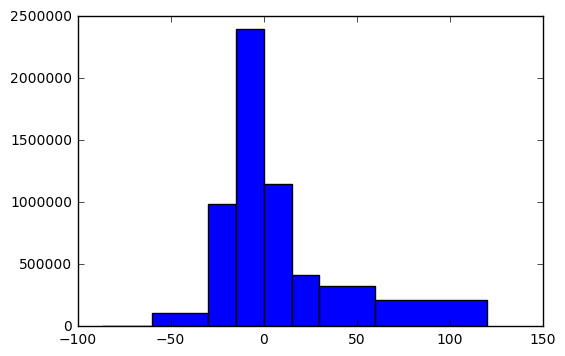

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Look at overall histogram
data_tuple = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])

heights = np.array(data_tuple[1])

# The bins are 1 > length than the values
full_bins = data_tuple[0]

# Bars are drawn from the left
mid_point_bins = full_bins[:-1]

# The width of a bar should be the range it maps in the data
widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]

# And now the bar should plot nicely
bar = plt.bar(mid_point_bins, heights, width=widths, color='b')

We can see here that there is a strong mean in our data around 0-15, with some right left, and that most of the data was falling either in `ArrDelayBucket` `0.0` or very nearly so in the next bin. This must make the bins hard to reckon for the classifier.

## Repartitioning `ArrDelayBucket`
This histogram seems to indicate that we might address our problem by re-bucketizing `ArrDelayBucket` into something more balanced. While the original schema of `<15,15-60,60+` seemed to make sense from a user perspective... it seems to have wrecked our model. So lets try something that respects the distribution of delay...

### Using Histograms to Determine Balanced Buckets
Before we dive in and change our buckets, lets play with defining different buckets for our histogram and see if we can create balanced bars! To play around with this without repeating ourselves, lets create a function `create_hist` to help.

In [10]:
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

### Visualizing the Original Bucketing Schema
First, lets check out the distribution of the data using the original bucketing scheme. Although the maximum arrival delay is 1971 minutes, let use 200 to keep our chart from distorting.

<Container object of 3 artists>

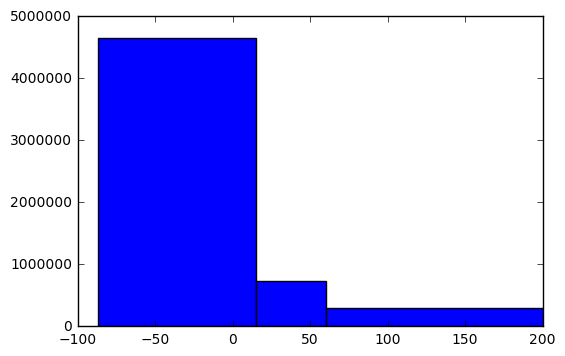

In [67]:
%matplotlib inline

buckets = [-87.0, 15, 60, 200]
rdd_histogram_data = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Wow, that is hugeloy... distorted! This doesn't look like a good scheme!

### Trying To Find Balanced Classes
Instead, lets try a bucketing scheme that might result in more balanced bars...

<Container object of 6 artists>

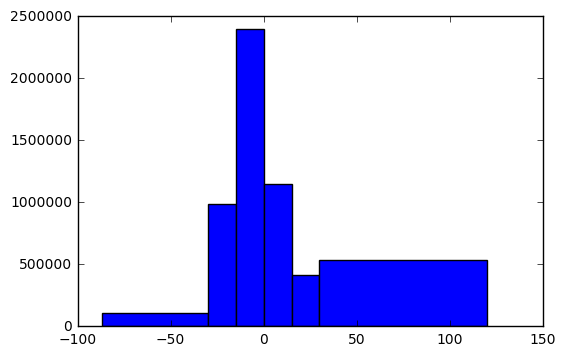

In [11]:
%matplotlib inline

buckets = [-87.0, -30, -15, 0, 15, 30, 120]
rdd_histogram_data = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Hmmmm lets try again.

<Container object of 5 artists>

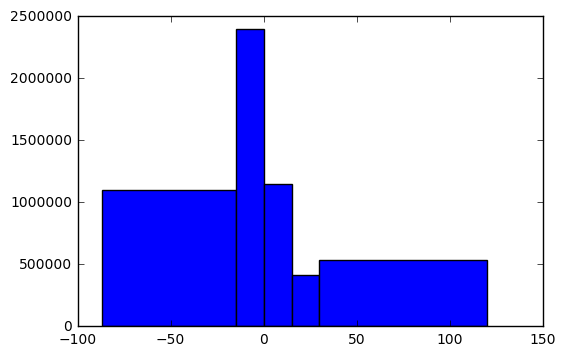

In [68]:
%matplotlib inline

buckets = [-87.0, -15, 0, 15, 30, 120]
rdd_histogram_data = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Lets knock out our smallest bucket and try again...

<Container object of 4 artists>

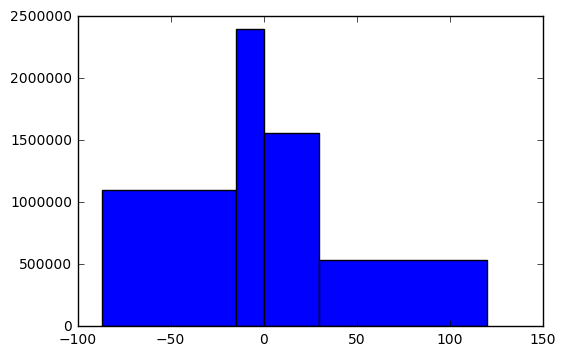

In [13]:
%matplotlib inline

buckets = [-87.0, -15, 0, 30, 120]
rdd_histogram_data = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

These look about right! The buckets `[-87, -15, 0, 30, 120]` correspond to human interprettable categories: `[early, on-time, late, very late]`. Lets use these buckets to recompute `ArrDelayBucket` and see if our problem goes away!

### Recomputing Partitions for `ArrDelayBucket`

Now that we have partitions that seem balanced, we can apply them to our features `DataFrame`. Lets recompute the Bucketizer and save it for use below.

In [14]:
from pyspark.ml.feature import Bucketizer

# Setup the Bucketizer
splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
arrival_bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)

# Save the model
arrival_bucketizer_path = "{}/models/arrival_bucketizer_2.0.bin".format(base_path)
arrival_bucketizer.write().overwrite().save(arrival_bucketizer_path)

### Inspecting the new `ArrDelayBucket`

Now lets apply the new buckets to our data, take a sample and take a peek...

In [15]:
# Apply it to our data
ml_bucketized_features = arrival_bucketizer.transform(features)

ml_bucketized_features\
  .select("ArrDelay", "ArrDelayBucket")\
  .sample(False, 0.01, 27)\
  .show(12)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|     8.0|           2.0|
|    49.0|           3.0|
|   151.0|           3.0|
|   -11.0|           1.0|
|    28.0|           2.0|
|     0.0|           2.0|
|    -6.0|           1.0|
|    -1.0|           1.0|
|   -18.0|           0.0|
|   -27.0|           0.0|
|    -8.0|           1.0|
|     1.0|           2.0|
+--------+--------------+
only showing top 12 rows



We're seeing examples of each label in our data. This is good. This looks differentiable. Now lets load all our models and see what happens...

## Loading Our Feature Models
Lets load all the models we've saved that vecotirize our raw data, using code from [`ch08/make_predictions.py`](https://github.com/rjurney/Agile_Data_Code_2/blob/master/ch08/make_predictions.py).

In [16]:
# Load the arrival delay bucketizer
from pyspark.ml.feature import Bucketizer
arrival_bucketizer_path = "{}/models/arrival_bucketizer_2.0.bin".format(base_path)
arrival_bucketizer = Bucketizer.load(arrival_bucketizer_path)

# Load the departure delay bucketizer
departure_bucketizer_path = "{}/models/departure_bucketizer.bin".format(base_path)
departure_bucketizer = Bucketizer.load(departure_bucketizer_path)

# Load all the string field vectorizer pipelines into a dict
from pyspark.ml import PipelineModel

string_vectorizer_pipeline_models = {}
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "FlightNum", "DepDelayBucket"]:
  string_pipeline_model_path = "{}/models/string_indexer_pipeline_model_{}.bin".format(
    base_path,
    column
  )
  string_pipeline_model = PipelineModel.load(string_pipeline_model_path)
  string_vectorizer_pipeline_models[column] = string_pipeline_model

# Load the numeric vector assembler
from pyspark.ml.feature import VectorAssembler
vector_assembler_path = "{}/models/numeric_vector_assembler.bin".format(base_path)
vector_assembler = VectorAssembler.load(vector_assembler_path)

# Load the final assembler
final_assembler_path = "{}/models/final_vector_assembler.bin".format(base_path)
final_assembler = VectorAssembler.load(final_assembler_path)

## Vectorize our Training Data
Having loaded all the models that vectorize our data, lets use them to vectorize our data! This will prepare it for re-training our classifier model in the next step.

In [17]:
# Bucketize the departure and arrival delays for classification
ml_bucketized_features = arrival_bucketizer.transform(features)

# Check the buckets
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(12)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
+--------+--------------+
only showing top 12 rows



In [18]:
# Vectorize string fields with the corresponding pipeline for that column
# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "FlightNum"]:
  string_pipeline_path = "{}/models/string_indexer_pipeline_{}.bin".format(
    base_path,
    column
  )
  string_pipeline_model = string_vectorizer_pipeline_models[column]
  ml_bucketized_features = string_pipeline_model.transform(ml_bucketized_features)
  ml_bucketized_features = ml_bucketized_features.drop(column + "_index")

# Vectorize numeric columns: DepDelay and Distance
ml_bucketized_features = vector_assembler.transform(ml_bucketized_features)

# Combine various features into one feature vector, 'features'
final_vectorized_features = final_assembler.transform(ml_bucketized_features)

Cleanup by dropping the individual vectors and check the data out...

In [19]:
# Drop the individual vector columns
feature_columns = ["Carrier_vec", "DayOfMonth_vec", "DayOfWeek_vec", "DayOfYear_vec",
                   "Origin_vec", "Dest_vec", "FlightNum_vec", "NumericFeatures_vec"]
for column in feature_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

final_vectorized_features.show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|(8009,[2,39,45,37...|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|(8009,[2,39,45,37...|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|         1|        4|        1|    -2.0| DFW|

## Retraining Our Classifier Model
And now we can retrain our classifier using the new `ArrDelayBuckets`, save it for use elsewhere and then test the new model and see if it still has the same problem.

### Test Run: 100K
Lets start out with just 100K training items to see that it runs ok... this way we don't wait a long time just to find out the model fails to fit.

In [20]:
# Inspect the finalized features - try first with just 100K items
limited_final_vectorized_features = final_vectorized_features.limit(100000)
limited_final_vectorized_features.show(5)

# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol="Features_vec", labelCol="ArrDelayBucket", predictionCol="Prediction")
model = rfc.fit(limited_final_vectorized_features)

print("Model trained on 100K items successfully!")

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|(8009,[2,39,45,37...|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|(8009,[2,39,45,37...|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|         1|        4|        1|    -2.0| DFW|

### Training Run: 5.7MM
The model having successfully fitted on limited data, lets train it on all 1.5 million flights and save the result to our `models/` directory.

In [21]:
# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol="Features_vec", labelCol="ArrDelayBucket", predictionCol="Prediction")
#model = rfc.fit(final_vectorized_features)
model = rfc.fit(limited_final_vectorized_features)

# Save the new model over the old one
model_output_path = "{}/models/spark_random_forest_classifier.flight_delays.2.0.bin".format(
  base_path
)
model.write().overwrite().save(model_output_path)

print("Model trained on 5.7MM items successfully!")

Model trained on 5.7MM items successfully!


## Testing Our New Classifier Model
Now we need to test and see whether the new model makes predictions other than 0.0 :) Lets make a prediction for our training data and count the different labels it predicts.

In [22]:
# Make the predictions...
predictions = model.transform(final_vectorized_features)
predictions.groupBy("Prediction").count().show()

+----------+-------+
|Prediction|  count|
+----------+-------+
|       1.0|  32887|
|       2.0|5681121|
+----------+-------+



Shit! Ok, the bucketing wasn't the issue. DAMN. Well, this is a learning experience. We'll have to figure out something else.

### In Which We Regroup And Figure Things Out
This seems more like a bug. What the hell is going on?

## Take 2: Simplify The Model
Lets pull all but one feature out and see what happens.

### Load the Data Again

In [23]:
schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

input_path = "{}/data/simple_flight_delay_features.json".format(
  base_path
)
features = spark.read.json(input_path, schema=schema)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 1, 10, 10), CRSDepTime=datetime.datetime(2015, 1, 1, 7, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2014, 12, 31), FlightNum='1024', Origin='ABQ')

### Bucketize Features

In [24]:
# Bucketize the departure and arrival delays for classification
ml_bucketized_features = arrival_bucketizer.transform(features)

### Only Vectorize the Numeric Columns
`DepDelay` and `Distance` will be the entirety of our model.

In [25]:
# Vectorize numeric columns: DepDelay and Distance
numeric_features = vector_assembler.transform(ml_bucketized_features)

### Train a New Random Forest Classifier Model

In [26]:
# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol="NumericFeatures_vec", labelCol="ArrDelayBucket", predictionCol="Prediction")
model = rfc.fit(numeric_features)

# Save the new model over the old one
model_output_path = "{}/models/spark_random_forest_classifier.flight_delays.3.0.bin".format(
  base_path
)
model.write().overwrite().save(model_output_path)

print("Model trained on 5.7MM items successfully!")

Model trained on 5.7MM items successfully!


### Make the Predictions

In [27]:
# Make the predictions...
predictions = model.transform(numeric_features)
predictions.show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|NumericFeatures_vec|       rawPrediction|         probability|Prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------------------+--------------------+--------------------+----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|       [14.0,569.0]|[0.04395894123984...|[0.00219794706199...|       2.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|     

### Check the Distribution of Predictions

In [28]:
predictions.registerTempTable("predictions")
spark.sql("""SELECT Prediction, COUNT(*) FROM predictions GROUP BY Prediction""").show()

+----------+--------+
|Prediction|count(1)|
+----------+--------+
|       0.0|  244210|
|       1.0| 3916886|
|       3.0|  542936|
|       2.0| 1009976|
+----------+--------+



### Compare to Actual Distribution

In [29]:
spark.sql("""Select ArrDelayBucket, COUNT(*) FROM predictions GROUP BY ArrDelayBucket""").show()

+--------------+--------+
|ArrDelayBucket|count(1)|
+--------------+--------+
|           0.0| 1098212|
|           1.0| 2402687|
|           3.0|  650604|
|           2.0| 1562505|
+--------------+--------+



Ok, this looks respectable, or at least... not completely erroneous! Now lets add in another feature and see what happens.

### Adding Back String Columns
Now, starting with just `Origin` and `Dest`, we'll try adding back the string columns and see what happens.

Start by creating a vector for each field, `Origin` and `Dest`, and check them out. Note that we repeat the numeric feature vectorization to refresh the `numeric_features` relation, which we modify by looping.

In [30]:
# Vectorize numeric columns: DepDelay and Distance
numeric_features = vector_assembler.transform(ml_bucketized_features)

# Vectorize string fields with the corresponding pipeline for that column
# Turn category fields into categoric feature vectors, then drop intermediate fields
string_columns = ["Origin", "Dest"]
for column in string_columns:
  string_pipeline_path = "{}/models/string_indexer_pipeline_{}.bin".format(
    base_path,
    column
  )
  string_pipeline_model = string_vectorizer_pipeline_models[column]
  numeric_features = string_pipeline_model.transform(numeric_features)
  numeric_features = numeric_features.drop(column + "_index")

numeric_features.show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------------------+----------------+---------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|NumericFeatures_vec|      Origin_vec|       Dest_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------------------+----------------+---------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|       [14.0,569.0]|(322,[53],[1.0])|(322,[2],[1.0])|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0

### Assemble Our Vectors
Now we need to assemble the `Origin`/`Dest`/`NumericFeatures` vectors into one `Features_vec`.

In [31]:
vector_columns = ["Origin_vec", "Dest_vec", "NumericFeatures_vec"]
final_assembler = VectorAssembler(
    inputCols=vector_columns,
    outputCol="Features_vec"
)
final_vectorized_features = final_assembler.transform(numeric_features)
for column in vector_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

final_vectorized_features.show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|(646,[53,324,644,...|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|(646,[53,324,644,...|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|         1|        4|        1|    -2.0| DFW|

### Retrain the Model
Note that as we add features, the model fitting slows down...

In [32]:
# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol="Features_vec", labelCol="ArrDelayBucket", predictionCol="Prediction")
model = rfc.fit(final_vectorized_features)

# Save the new model over the old one
model_output_path = "{}/models/spark_random_forest_classifier.flight_delays.4.0.bin".format(
  base_path
)
model.write().overwrite().save(model_output_path)

print("Model trained on 5.7MM items successfully!")

Model trained on 5.7MM items successfully!


### Make our Predictions

In [33]:
# Make the predictions...
predictions = model.transform(final_vectorized_features)
predictions.show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|Prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+--------------------+--------------------+----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|(646,[53,324,644,...|[3.65207272881038...|[0.18260363644051...|       1.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1| 

Uh oh... all 1.0s...

### Check that the Results are Sane
And drum roll... are the results sane?

In [34]:
predictions.registerTempTable("predictions")
spark.sql("""SELECT Prediction, COUNT(*) FROM predictions GROUP BY Prediction""").show()

+----------+--------+
|Prediction|count(1)|
+----------+--------+
|       1.0| 5699785|
|       3.0|   14223|
+----------+--------+



So... how can the performance of the model completely disappear when we add `Origin` and `Dest`? Even if these items have no contribution to the model... shouldn't it still compensate? It is a decision tree!

### Classifier Model Feature Importances
Lets look at the feature importances. What are they?

In [35]:
feature_importances = model.featureImportances
feature_importances

SparseVector(646, {0: 0.0303, 1: 0.061, 2: 0.0, 3: 0.0001, 4: 0.0087, 6: 0.0077, 7: 0.0048, 8: 0.0, 9: 0.0, 10: 0.0051, 13: 0.0006, 14: 0.0012, 15: 0.0657, 16: 0.001, 17: 0.0416, 18: 0.0001, 19: 0.0, 20: 0.0, 21: 0.0057, 22: 0.0048, 23: 0.0022, 25: 0.0006, 27: 0.011, 28: 0.0246, 29: 0.0004, 31: 0.0, 32: 0.0119, 33: 0.0138, 34: 0.0, 35: 0.0001, 36: 0.0003, 37: 0.013, 38: 0.0152, 39: 0.001, 40: 0.006, 41: 0.0009, 42: 0.0, 43: 0.0005, 46: 0.0, 47: 0.0004, 48: 0.0, 51: 0.0003, 53: 0.0002, 54: 0.0071, 56: 0.0002, 58: 0.0002, 61: 0.0, 66: 0.0, 67: 0.0002, 75: 0.0, 76: 0.0002, 79: 0.0, 84: 0.0, 86: 0.0025, 102: 0.0, 103: 0.0, 104: 0.0, 126: 0.0001, 127: 0.0, 137: 0.0, 138: 0.0, 139: 0.0001, 142: 0.0, 151: 0.0002, 155: 0.0004, 158: 0.0, 190: 0.0002, 195: 0.0001, 232: 0.0003, 301: 0.0, 322: 0.0202, 323: 0.0584, 324: 0.0072, 325: 0.0015, 326: 0.0009, 327: 0.0298, 328: 0.0036, 329: 0.0, 330: 0.0006, 331: 0.0004, 332: 0.0001, 334: 0.0007, 335: 0.0005, 336: 0.0006, 337: 0.0175, 338: 0.0048, 339: 0.

### Great, WTF Do I Do with This SparseVector?

I have no idea what to do with this. This tells me nothing. How do I reverse the process to get the feature names?

In [36]:
# I dunno

## Try Combining `Origin`/`Dest` Into One `Route` Column

Try making it one feature, the route as defined by the `Origin`/`Dest` pair.

In [37]:
# Bucketize the departure and arrival delays for classification
ml_bucketized_features = arrival_bucketizer.transform(features)
from pyspark.sql.functions import lit, concat
features_with_route = ml_bucketized_features.withColumn(
  'Route',
  concat(
    ml_bucketized_features.Origin,
    lit('-'),
    ml_bucketized_features.Dest
  )
)
features_with_route.show(6)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|ABQ-DFW|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|ABQ-DFW|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|         1|        4|        1|    -2.0| DFW|   569.0|2014-12-31|      336|   ABQ|           3.0|ABQ-DFW|
|   

## Vectorize `Route`

Now we must create a string indexer pipeline for the `Route` column.

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorIndexer

route_string_indexer = StringIndexer(
  inputCol='Route',
  outputCol='Route' + "_index"
)

route_one_hot_encoder = OneHotEncoder(
  dropLast=False,
  inputCol='Route' + "_index",
  outputCol='Route' + "_vec"
)
route_string_pipeline = Pipeline(
  stages=[route_string_indexer, route_one_hot_encoder]
)

# Fit/transform to apply to the data
route_string_pipeline_model = route_string_pipeline.fit(features_with_route)
features_with_route_vec = route_string_pipeline_model.transform(features_with_route)

# Drop the intermediate index
features_with_route_vec = features_with_route_vec.drop("Route" + "_index")

# Save the pipeline model
route_string_pipeline_output_path = "{}/models/string_indexer_pipeline_model_{}.bin".format(
  base_path,
  "Route"
)
route_string_pipeline_model.write().overwrite().save(route_string_pipeline_output_path)

print("Saved route string pipeline model to {}...".format(route_string_pipeline_output_path))

Saved route string pipeline model to ../models/string_indexer_pipeline_model_Route.bin...


### Verify `Route_vec`
And lets check the resulting `Route_vec` column...

In [39]:
# Show a sample of the output
features_with_route_vec.sample(False, 0.001, 11).show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|          Route_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-------------------+
|    38.0|2015-01-01 08:50:...|2015-01-01 03:45:...|     AA|         1|        4|        1|    29.0| DFW|  1235.0|2014-12-31|     2419|   LAX|           3.0|LAX-DFW|  (4657,[45],[1.0])|
|    53.0|2015-01-01 14:04:...|2015-01-01 12:55:...|     B6|         1|        4|        1|    62.0| BOS|   187.0|2014-12-31|      418|   JFK|           3.0|JFK-BOS| (4657,[129],[1.0])|
|     1.0|2015-01-01 13:05:...|2015-01-01 09:54:...|     UA|         1

Note that the thing exploded in size, up to 4657 routes.

### Recreate `NumericFeatures_vec`
We need to recreate the vectors for our numeric columns, `DepDelay` and `Distance`.

In [40]:
# Load the numeric vector assembler
from pyspark.ml.feature import VectorAssembler
vector_assembler_path = "{}/models/numeric_vector_assembler.bin".format(base_path)
vector_assembler = VectorAssembler.load(vector_assembler_path)

# Vectorize numeric columns: DepDelay and Distance
features_with_route_and_numeric = vector_assembler.transform(features_with_route_vec)
features_with_route_and_numeric.show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+------------------+-------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|         Route_vec|NumericFeatures_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+------------------+-------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|ABQ-DFW|(4657,[938],[1.0])|       [14.0,569.0]|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|ABQ-DFW|(4657,[938],[1.

### Combine `Route_vec` with `NumericFeatures_vec`
Now we need to combine our new `Route_vec` with our numeric features. 

First we create and save the new `VectorAssembler`

In [43]:
# Create and save the VectorAssembler
route_feature_columns = ["Route_vec", "NumericFeatures_vec"]
route_final_assembler = VectorAssembler(
    inputCols=route_feature_columns,
    outputCol="Features_vec"
)
route_final_assembler_path = "{}/models/final_vector_assembler_simplified_with_route.bin".format(base_path)
route_final_assembler.write().overwrite().save(route_final_assembler_path)

print("Created and stored VectorAssembler...")

Created and stored VectorAssembler...


Apply the `VectorAssembler` via `transform` and check it out.

In [44]:
final_vectorized_features_with_route = route_final_assembler.transform(features_with_route_and_numeric)
final_vectorized_features_with_route.sample(False, 0.001, 99).show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-------------------+-------------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|          Route_vec|NumericFeatures_vec|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-------------------+-------------------+--------------------+
|    32.0|2015-01-01 04:35:...|2015-01-01 03:10:...|     AA|         1|        4|        1|    -1.0| HDN|   769.0|2014-12-31|       35|   DFW|           3.0|DFW-HDN|(4657,[3987],[1.0])|       [-1.0,769.0]|(4659,[3987,4657,...|
|   -10.0|2015-01-01 05:20:...|2015-01-01 03:55:...|     AA|         1|        4|        1| 

And drop the intermediate feature vector columns.

In [45]:
for column in route_feature_columns:
  final_vectorized_features_with_route = final_vectorized_features_with_route.drop(column)

final_vectorized_features_with_route.sample(False, 0.001, 12).show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+--------------------+
|    -2.0|2015-01-01 06:19:...|2015-01-01 04:35:...|     B6|         1|        4|        1|    -1.0| IAD|   413.0|2014-12-31|      457|   BOS|           1.0|BOS-IAD|(4659,[774,4657,4...|
|   -34.0|2015-01-01 11:38:...|2015-01-01 08:10:...|     B6|         1|        4|        1|    -3.0| LAX|  2475.0|2014-12-31|      423|   JFK|           0.0|JFK-LAX|(4659,[2,4657,465...|
|   -11.0|2015-01-01 09:54:...|2015-01-01 09:30:...|     DL|     

### Create a New Random Forest Classifier Model
We need a new model that is fitted with our new feature vectors.

In [47]:
# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
rfc = RandomForestClassifier(featuresCol="Features_vec", labelCol="ArrDelayBucket", predictionCol="Prediction")
model = rfc.fit(final_vectorized_features)
# Save the new model over the old one
model_output_path = "{}/models/spark_random_forest_classifier.flight_delays_simplified_with_route.bin".format(
  base_path
)
model.write().overwrite().save(model_output_path)
print("Model trained on 5.7MM items successfully!")

In [49]:
predictions = model.transform(final_vectorized_features)
predictions.groupBy("Prediction").count().show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|Prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+--------------------+--------------------+--------------------+----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|(646,[53,324,644,...|[3.66319242779629...|[0.18315962138981...|       1.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1| 

## Try Just StringIndexer
The internet says not to use `OneHotEncoder`, so I'll try that.

In [52]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorIndexer

route_string_indexer = StringIndexer(
  inputCol='Route',
  outputCol='Route' + "_index"
)
route_string_indexer_model = route_string_indexer.fit(features_with_route)

# Fit/transform to apply to the data
features_with_route_index = route_string_indexer_model.transform(features_with_route)
features_with_route_index.show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|Route_index|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|           2.0|ABQ-DFW|      938.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|           2.0|ABQ-DFW|      938.0|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|         1|        4|        1|    -2.0| DFW|   56

Now compose the `Route_index` with the `DepDelay` and `Distance` columns

In [53]:
# Handle continuous, numeric fields by combining them into one feature vector
new_numeric_columns = ["DepDelay", "Distance", "Route_index"]
route_index_vector_assembler = VectorAssembler(
  inputCols=new_numeric_columns,
  outputCol="Features_vec"
)
final_route_index_features = route_index_vector_assembler.transform(features_with_route_index)

# Save the numeric vector assembler
route_index_vector_assembler_path = "{}/models/numeric_vector_assembler_route_index.bin".format(base_path)
route_index_vector_assembler.write().overwrite().save(route_index_vector_assembler_path)

In [55]:
final_route_index_features.sample(False,0.001,88).show(5)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-----------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|ArrDelayBucket|  Route|Route_index|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+--------------+-------+-----------+--------------------+
|   -19.0|2015-01-01 13:00:...|2015-01-01 04:45:...|     AA|         1|        4|        1|     0.0| BOS|  2611.0|2014-12-31|      202|   LAX|           0.0|LAX-BOS|      206.0|  [0.0,2611.0,206.0]|
|    -7.0|2015-01-01 07:14:...|2015-01-01 05:30:...|     AS|         1|        4|        1|    -6.0| SEA|   605.0|2014-12-31|      359|   SMF|           1.0|SMF-SEA|      280.0|  [-6.0,605.0,280.0]|
|    

Train a new model on this new set of features.

In [61]:
# Instantiate and fit random forest classifier on all the data
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
rfc = RandomForestClassifier(featuresCol="Features_vec", labelCol="ArrDelayBucket", predictionCol="Prediction", maxBins=4657)
model = rfc.fit(final_route_index_features)
# Save the new model over the old one
model_output_path = "{}/models/spark_random_forest_classifier.flight_delays_simplified_with_route_index.bin".format(
  base_path
)
model.write().overwrite().save(model_output_path)
print("Model trained on 5.7MM items successfully!")

Model trained on 5.7MM items successfully!


And make predictions on the training data and inspect their distribution.

In [64]:
predictions = model.transform(final_route_index_features)
predictions.groupBy("Prediction").count().show()

+----------+-------+
|Prediction|  count|
+----------+-------+
|       0.0|   1165|
|       1.0|4143264|
|       3.0| 565640|
|       2.0|1003939|
+----------+-------+



It works!

In [65]:
predictions.groupBy("ArrDelayBucket").count().show()

+--------------+-------+
|ArrDelayBucket|  count|
+--------------+-------+
|           0.0|1098212|
|           1.0|2402687|
|           3.0| 650604|
|           2.0|1562505|
+--------------+-------+



## Solution! We Sovled the Problem!

We were mistaken in using `OneHotEncoder` on the values of `StringIndexerModel`, we should have just used `VectorAssembler` directly on the string indexes. After changing the `maxBins` parameter of our `RandomForestClassifier`, it works!